In [1]:
import numpy as np
import pandas as pd
import cv2 as cv 
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
import seaborn as sns
import glob

# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 
#from tensorflow.keras.utils  import load_img
#from tensorflow.keras.utils import img_to_array


# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os

from random import randint
#import pickle

from numpy import genfromtxt

In [2]:
from sklearn.metrics.pairwise import euclidean_distances
from random import sample
from  sklearn.metrics import silhouette_score

In [3]:
lista_archivos=glob.glob(r"C:\Users\Marie\Documents\MasterUBA\DMcyt\tp1\arroz\Rice_Image_Dataset/**/*.jpg", recursive = True)

In [4]:
#lista_archivos=sample(lista_archivos_total, 5000)

In [5]:
len(lista_archivos)

75000

In [6]:
df=pd.DataFrame({"Archivo":lista_archivos})

In [7]:
df["label"]=np.where(df.Archivo.str.contains("Arborio"),"Arborio",None)
df["label"]=np.where(df.Archivo.str.contains("Basmati"),"Basmati",df["label"])
df["label"]=np.where(df.Archivo.str.contains("Ipsala"),"Ipsala",df["label"])
df["label"]=np.where(df.Archivo.str.contains("Jasmine"),"Jasmine",df["label"])
df["label"]=np.where(df.Archivo.str.contains("Karacadag"),"Karacadag",df["label"])

In [8]:
df.label.value_counts().sort_index()

Arborio      15000
Basmati      15000
Ipsala       15000
Jasmine      15000
Karacadag    15000
Name: label, dtype: int64

# Exploracion

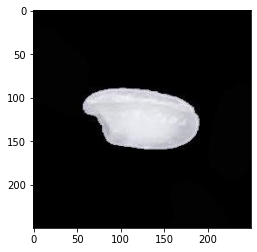

In [9]:
img = cv.imread(lista_archivos[0])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

# Extracción de características features

In [10]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [11]:
def preprocess(lista, model):
    
    datays = {}
    for i in lista:
      featuress = extract_features(i, model)
      datays[i] = featuress               
    # lista de filenames
    filenmss = np.array(list(datays.keys()))
    
    # lista de features
    featsss = np.array(list(datays.values()))

    # reshape 4096 features por el número de imagens 
    featsss = featsss.reshape(-1,4096)
    return filenmss, featsss

In [12]:
def extract_features(file, model):
    # levanta imagen como array 224x224 
    img = load_img(file, target_size=(224,224))
    # convierte img a numpy array (originalmente es 'PIL.Image.Image') 
    img = np.array(img) 
    # reshape para tener formato necesario para el modelo (num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepara imagen para modelo (función de keras)
    imgx = preprocess_input(reshaped_img)
    # extrae features
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [13]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(gps,cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = gps
    # only allow up to 30 images to be shown at a time
    if len(files) > 10:
        print(f"Clipping cluster size from {len(files)} to 10")
        files = files[:9]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(1,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.title('Cluster n:' + str(cluster) )
        plt.axis('off')

In [ ]:
#names, feat = preprocess(path, model) #solo se corre una vez y se guarda

In [14]:
names_pd = pd.read_csv(r'C:\Users\Marie\Documents\MasterUBA\DMcyt\tp1\arroz\Rice_Image_Dataset\names_pd.csv', index_col=0)

In [15]:
names = names_pd.to_numpy()

In [16]:
feat_pd = pd.read_csv(r"C:\Users\Marie\Documents\MasterUBA\DMcyt\tp1\arroz\Rice_Image_Dataset\feat_pd.csv", index_col=0)

In [17]:
feat = feat_pd.to_numpy()

In [18]:
feat.shape

(75000, 4096)

In [19]:
label = df['label'].tolist()
unique_labels = list(set(label))

In [20]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22) # 
pca.fit(feat)
x = pca.transform(feat)

In [21]:
x.shape

(75000, 100)

In [22]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 4096
Components after PCA: 100


# Kmean x default

In [23]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(x)

KMeans(n_clusters=5)

In [24]:
kmeans.labels_

array([0, 1, 0, ..., 3, 3, 3])

In [25]:
df_conf = df.copy()
df_conf["Kmeans_x"] = kmeans.labels_
df_conf=df_conf[["label", "Kmeans_x"]]

In [26]:
confusion=pd.crosstab(df_conf["label"], df_conf["Kmeans_x"])
confusion

Kmeans_x,0,1,2,3,4
label,,,,,
Arborio,5903,7347,172,1506,72
Basmati,56,6,7918,0,7020
Ipsala,7438,7396,90,58,18
Jasmine,1710,499,7107,4,5680
Karacadag,148,1113,0,13739,0


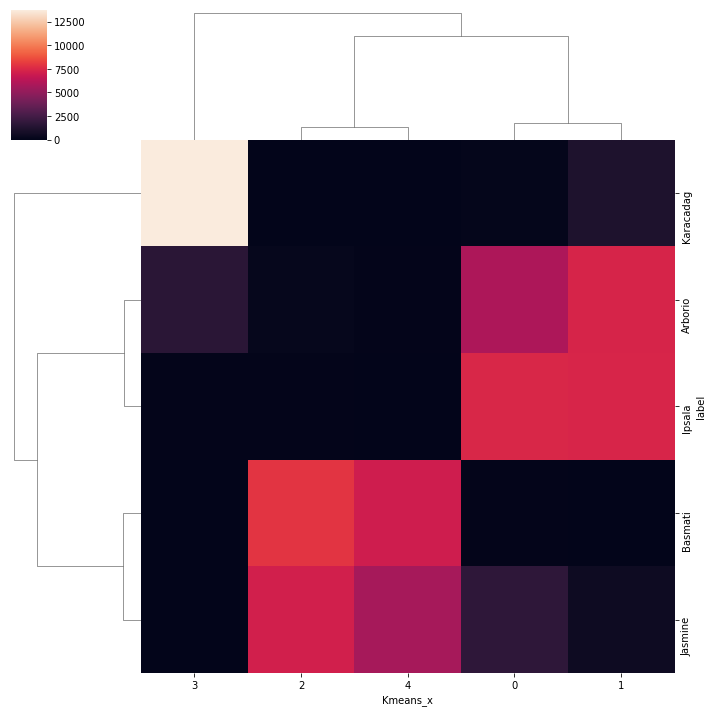

In [27]:
sns.clustermap(confusion)

In [28]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

In [29]:
print(vanDongen(confusion))

0.5305169463667091


In [30]:
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(df["label"],kmeans.labels_)) ##probar con label encodeadas a numeros

0.4020457835115118


In [32]:
silhouette_score(x, kmeans.labels_)

0.1341199918752301

In [33]:
kmeans.inertia_

65592463.344028175

In [37]:
range_k = [i for i in range(2,20)]
silh = []
sse = []
for k in range_k:
    KM = KMeans(n_clusters=k).fit(x)

    silh.append(silhouette_score(x, KM.labels_)) #, metric='precomputed'
    sse.append(KM.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse,'r.-')
plt.ylabel('SSE')
plt.show()

# Kmean feat default

In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(feat)

In [ ]:
df_conf = df.copy()
df_conf["Kmeans_feat"] = kmeans.labels_
df_conf=df_conf[["label", "Kmeans_feat"]]

In [ ]:
confusion=pd.crosstab(df_conf["label"], df_conf["Kmeans_feat"])
confusion

In [ ]:
sns.clustermap(confusion)

In [ ]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

In [ ]:
print(vanDongen(confusion))

In [ ]:
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(df["label"],kmeans.labels_)) ##probar con label encodeadas a numeros

In [ ]:
silhouette_score(x, kmeans.labels_)

In [ ]:
kmeans.inertia_

In [ ]:
range_k = [i for i in range(2,20)]
silh = []
sse = []
for k in range_k:
    KM = KMeans(n_clusters=k).fit(x)

    silh.append(silhouette_score(x, KM.labels_)) #, metric='precomputed'
    sse.append(KM.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse,'r.-')
plt.ylabel('SSE')
plt.show()
